# Assignment 4 - Adrian Sandoval-Vargas

Importing all necessary libraries

In [1]:
import torchvision
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.cluster import KMeans

## Data Acquisition

Since there is no prediction analysis, I figured using the test set to be more suitable as it has much less images so processing will be faster.

In [2]:
# Normalization transform
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,)) ])

# Train dataset
dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, 
download=True, transform=transform)

## PCA Analysis

To begin lets do some analysis on find a good *N* for PCA's n_components. Lets convert tensors to numpy arrays and fit our test PCA model.

In [3]:
images = [i.flatten().numpy() for i in dataset.data]
pca_t = PCA()
X_r = pca_t.fit(images)

Lets limit our PCA explained_variance_ratio to 95%.

In [4]:
ninety_five_index = np.where((np.cumsum(pca_t.explained_variance_ratio_) > .950) & (np.cumsum(pca_t.explained_variance_ratio_) < .951))[0][0]

Plotting the results.

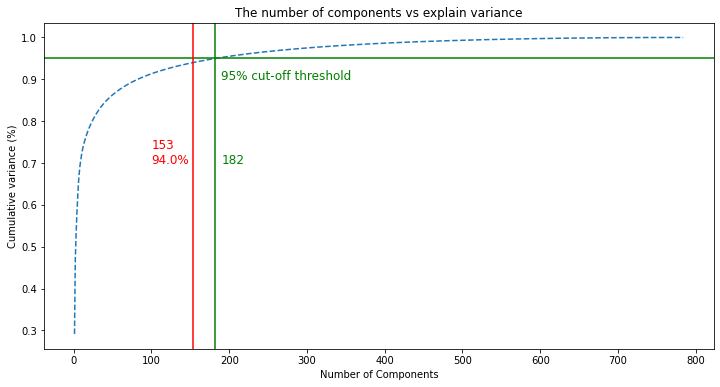

In [5]:
plt.figure(figsize=(12,6))
plt.plot(np.arange(1, len(images[0])+1, step=1), np.cumsum(pca_t.explained_variance_ratio_), linestyle="--")
plt.xlabel('Number of Components')
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components vs explain variance')
plt.axhline(y=0.95, color='g', linestyle='-')
plt.text(190, 0.90, f'95% cut-off threshold', color = 'green', fontsize=12);
plt.axvline(x=ninety_five_index, color='g', linestyle='-')
plt.text(190, 0.70, f'{ninety_five_index}', color = 'green', fontsize=12)
plt.axvline(x=153, color='r', linestyle='-')
plt.text(100, 0.70, f'{153}\n{np.cumsum(pca_t.explained_variance_ratio_)[153]*100:.1f}%', color = 'r', fontsize=12);

As we can see from the image above, obtaining 95% of our data significantly reduces our dimentionality. Further, we can see that the slope between 153 and 182 increases at a higher rate than 183 to 784. This can be used to find optimal PCA components, with data loss of course. The image below shows a close up of the component vs cumulative explained variance.

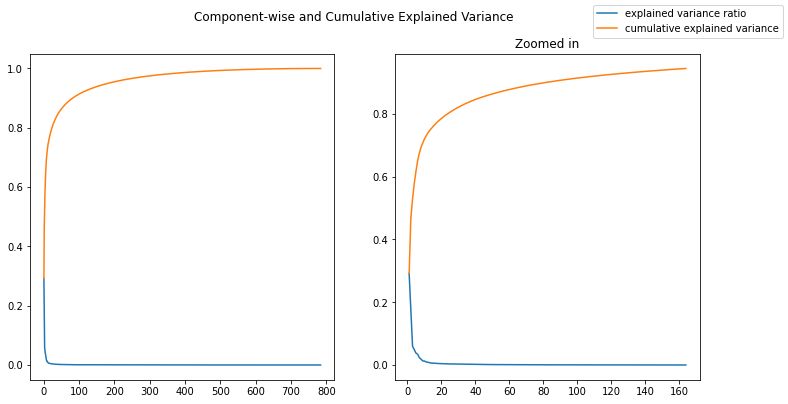

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle("Component-wise and Cumulative Explained Variance");
ax1.plot(range(1, len(images[0])+1), pca_t.explained_variance_ratio_)
ax1.plot(range(1, len(images[0])+1), np.cumsum(pca_t.explained_variance_ratio_))
ax2.plot(np.arange(1, 165,step=1), pca_t.explained_variance_ratio_[:164])
ax2.plot(np.arange(1, 165,step=1), np.cumsum(pca_t.explained_variance_ratio_)[:164])
ax2.set_title('Zoomed in');
fig.legend(['explained variance ratio', 'cumulative explained variance'])


This suggests that much doesn't change after 20 components. With 20 components, we would retain *~80%* of the data with only *2.5%* of the data. Which is impressive. Never-the-less, for this assignment I have decided to go with *94%* data retention which correlates **153** components and it's just *19.5%* of the all the components. 

In [7]:
pca = PCA(n_components=153)
X_reduced = pca.fit_transform(images)

## Visualize PCA Eigen images

In [8]:
# helper function to plot the eigen images
def plot_images(data, n):
    fig = plt.figure(figsize=(12,6))
    fig.suptitle('Eight Eigen Images')
    for i in range(1, n+1):
        val = '24' + str(i)
        ax = fig.add_subplot(int(val))
        ax.imshow(data[i-1].reshape(28,28), cmap="gray")

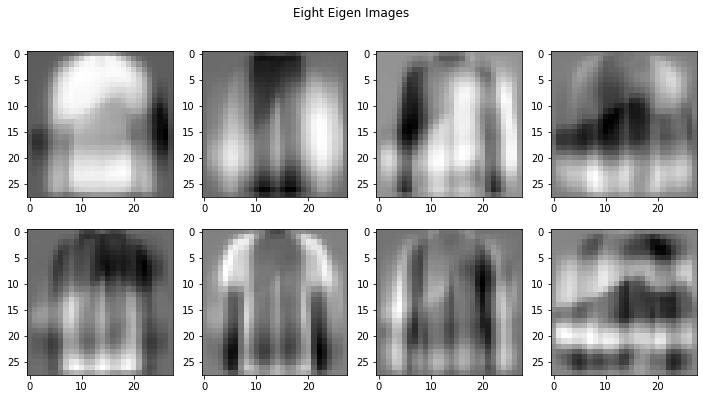

In [9]:
n = 8
eigenimages = pca.components_[:n]
plot_images(eigenimages, n)

The PCA Eigen Images show embedded images of all classes.

## Reconstructing images from each class with PCA's Eigen Vectors.

In [10]:
# Heler function to plot the reconstructed images
def plot_reconstructed(data, indexes):
    fig = plt.figure(figsize=(8,4))
    fig.suptitle('Eight Eigen Images')
    
    r_images = []
    o_images = []
    for i in indexes:
        r_images.append(data[i])
        o_images.append(images[i])

    _, axs = plt.subplots(10, 3, figsize=(12, 24), sharex=True, sharey=True)
    
    for i in range(1, len(indexes)+1):
        axs[i-1][0].imshow(o_images[i-1].reshape(28,28), cmap="gray")
        axs[i-1][0].title.set_text("Original")
        axs[i-1][1].imshow(r_images[i-1].reshape(28,28), cmap="gray")
        axs[i-1][1].title.set_text("Reconstruction")
        axs[i-1][2].imshow(np.abs(o_images[i-1] - r_images[i-1]).reshape(28, 28), cmap="gray")
        axs[i-1][2].title.set_text(f"Original-Reconstruction Difference\nRMSE: {mean_squared_error(o_images[i-1], r_images[i-1], squared=False):.2f}")
        
    plt.subplots_adjust(top=1.4)
    plt.show()

To reconstruct the images, we first must find indexes of 1 image per class. Then use PCA's inverse_transform to obtain the reconstructed images from the reduced images.

<Figure size 576x288 with 0 Axes>

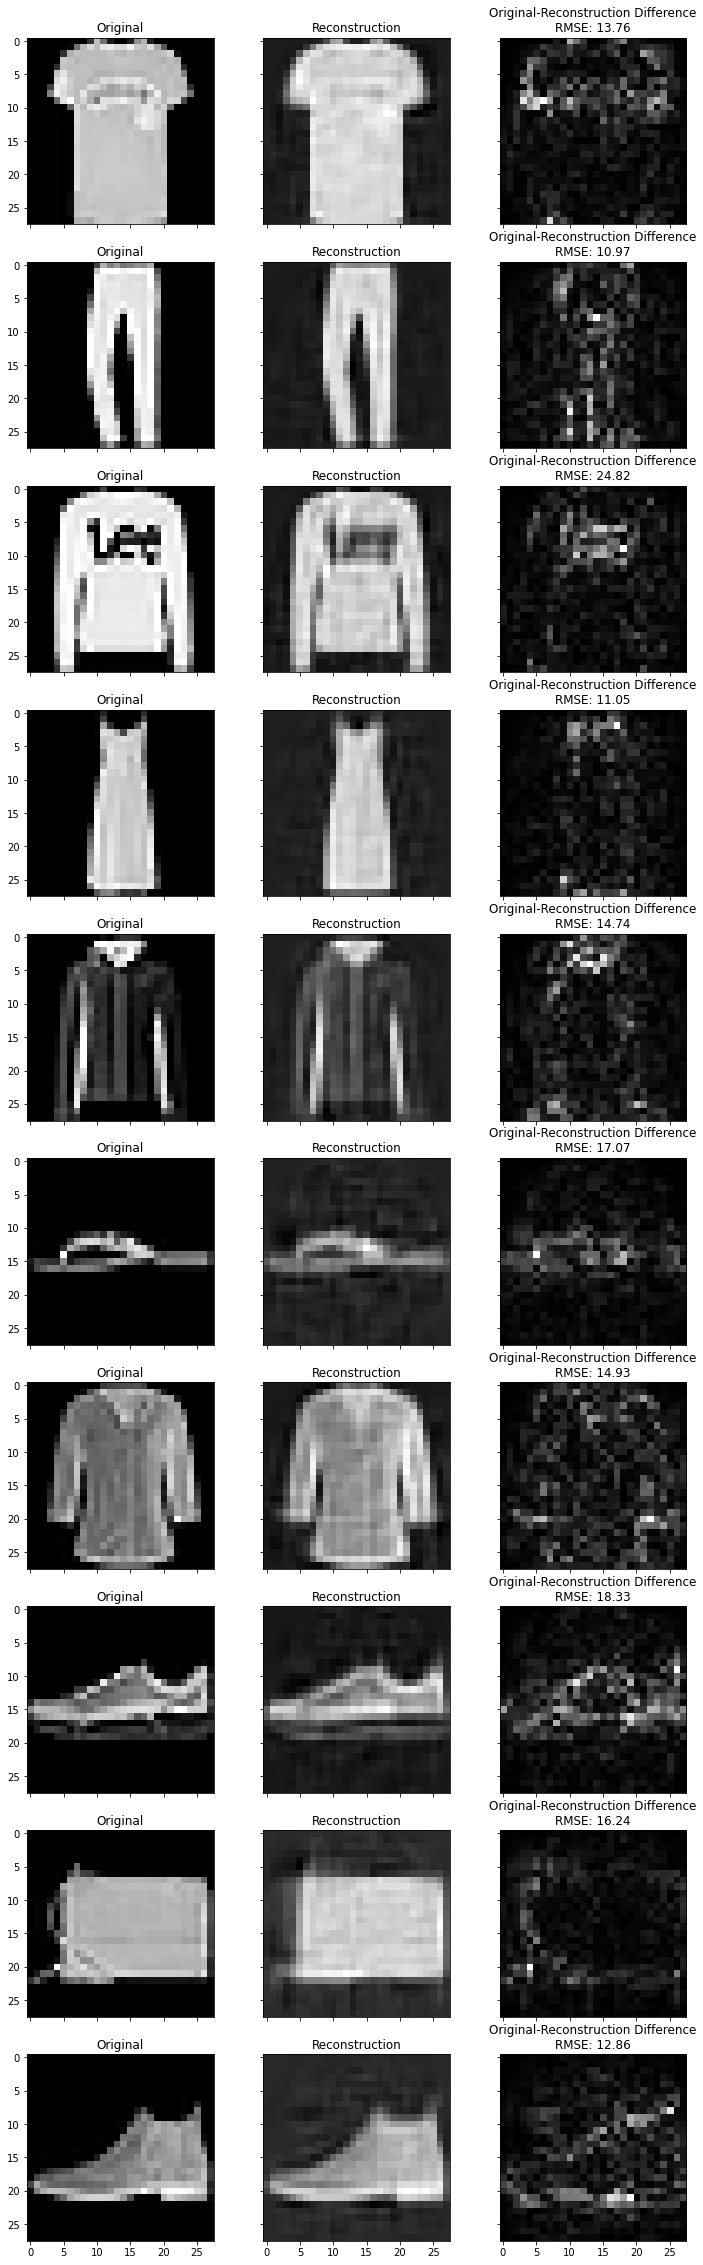

In [11]:
indexes = []
for i in range(10):
    indexes.append(np.where(dataset.targets.numpy() == i)[0][0])
X_recovered = pca.inverse_transform(X_reduced)
plot_reconstructed(X_recovered, indexes)

As we can see for each class the recontructions are fairly good. The best RMSE is *10.60* which was for the dress followed by pants with *10.78*. It does worse with more detail. For example, the graphic tee with "lee" has an RMSE more than double of the best reconstruction with *24.93*. Similary, the shoe and sandal perform better than the "lee" shirt but worse than the dress. One class that I found interesting was the purse. This was because despite begin almost a solid block it performed worse than most objects. This might be an isolated instance as it has details like the purse's lanyard and it failed to reconstruct it.

## Visualizing Original and PCA space using t-SNE

Lets now visualize the Original and PCA space using t-SNE. For plotting reasons, the number of components are 2 but these should have an affect as both original and pca reconstructed images are being reduced further.

In [12]:
tsne = TSNE(n_components=2, random_state=120)
z = tsne.fit_transform(images)
df = pd.DataFrame()
df["y"] = dataset.targets
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

tsne_1 = TSNE(n_components=2, random_state=120)

z_1 = tsne_1.fit_transform(X_recovered)
df_1 = pd.DataFrame()
df_1["y"] = dataset.targets
df_1["comp-1"] = z_1[:,0]
df_1["comp-2"] = z_1[:,1]

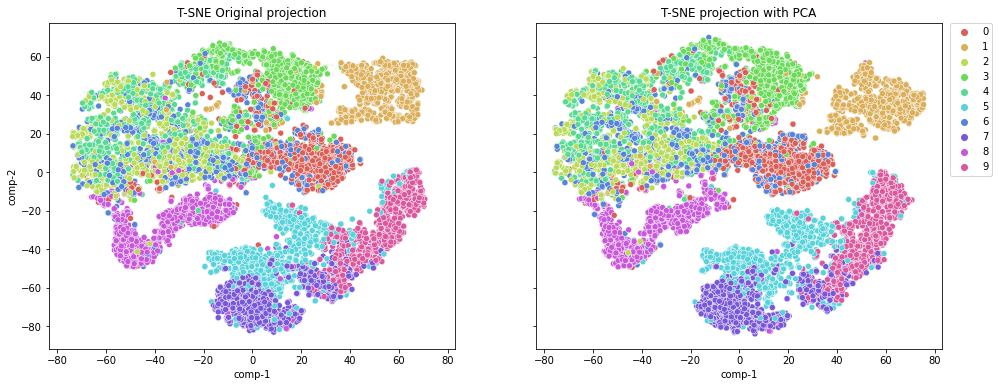

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,6), sharex=True, sharey=True)
tn1 = sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(), palette=sns.color_palette("hls", 10), data=df, ax=ax1).set(title="T-SNE Original projection")
ax1.legend_.remove()
tn2 = sns.scatterplot(x="comp-1", y="comp-2", hue=df_1.y.tolist(), palette=sns.color_palette("hls", 10), data=df_1, ax=ax2).set(title="T-SNE projection with PCA")
ax2.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

We can observe that class 1 for the most part is a distinctly separate class. Classes 5, 7, and 9 are separate from the majority but have similarities amongst eachother. Class 8 is in the vicinity of the majority of the classes but has it's distinct shape. The majority of class 0 has it's form but more spread out and class 6 overlaps more. Now, classes 2, 3, 4, and 6 are for the most part overlapping eachother. 

Some slight differences between the original and PCA space are the shape of the class clusters. For example, class 8 seems more narrower. Class 1 takes a slightly different shape. Class 0 seems to compress a little and class 5 cannot stretch all the way near the majority of the clusters. Also class 5 seems a bit more sparsed in the vicinity of classes 7 and 9. 

## Classes for linear autoencoder and non linear autoencoder
Below are the classes i'll be using for the rest of the assignment. This includes the Linear and Non Linear Autoencoders.

In [14]:
class NonLinearAutoencoder(torch.nn.Module):
    '''
     Non Linear Autoencoder
    '''
    def __init__(self, n_features, n_hidden):
        super(NonLinearAutoencoder, self).__init__()
        # ENCODER
        self.linear_1 = torch.nn.Linear(n_features, n_hidden)
        # DECODER
        self.linear_2 = torch.nn.Linear(n_hidden, n_features)

    def forward(self, x):
        # ENCODER
        encoded = self.linear_1(x)
        encoded = F.relu(encoded)
        ## DECODER
        logits = self.linear_2(encoded)
        decoded = F.sigmoid(logits)
        return decoded
    
    # train the model
    def train(self, epochs, loader, learning_rate):
        cost_fn = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        outputs = []

        # Traing the model
        for epoch in range(epochs):
            for batch_idx, (features, targets) in enumerate(loader):
                img = Variable(features.view(-1, 28*28))
                
                # FORWARD AND BACK PROP
                reconstruction = self.forward(img)
                cost = cost_fn(reconstruction, img)
                optimizer.zero_grad()
                cost.backward()
                
                # UPDATE MODEL PARAMETERS
                optimizer.step()
                # LOGGING
                if not batch_idx & 50:
                    print(f'Epoch: {(epoch+1)}, Batch: {batch_idx}, Cost: {cost.data.item():.4f}', end=" | ")
                if epoch == 4:
                    outputs.append(reconstruction)
        return outputs
        

class LinearAutoencoder(torch.nn.Module):
    '''
     Linear Autoencoder
    '''
    def __init__(self, n_features, n_hidden):
        super(LinearAutoencoder, self).__init__()
        # ENCODER
        self.linear_1 = torch.nn.Linear(n_features, n_hidden)
        # DECODER
        self.linear_2 = torch.nn.Linear(n_hidden, n_features)

    def forward(self, x):
        # ENCODER
        encoded = self.linear_1(x)
        return self.linear_2(encoded)
    
    # train the model
    def train(self, epochs, loader, learning_rate):
        cost_fn = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        outputs = []

        # Traing the model
        for epoch in range(epochs):
            for batch_idx, (features, targets) in enumerate(loader):
                img = Variable(features.view(-1, 28*28))
                
                # FORWARD AND BACK PROP
                reconstruction = self.forward(img)
                cost = cost_fn(reconstruction, img)
                optimizer.zero_grad()
                cost.backward()
                
                # UPDATE MODEL PARAMETERS
                optimizer.step()
                # LOGGING
                if not batch_idx & 50:
                    print(f'Epoch: {(epoch+1)}, Batch: {batch_idx}, Cost: {cost.data.item():.4f}', end=" | ")
                if epoch == 4:
                    outputs.append(reconstruction)
        return outputs

## The linear Autoencoder

The linear Autoenconder is defined above. The hyper parameters are initialized here and are also used for the Nonlinear Autoencoder. This model will contain *8* neurons in the hidden layer, with *5* epochs, batch size of *128*, and a learning rate of *0.005*.

In [15]:
learning_rate = 0.005
epochs = 5
batch_size = 128

n_features = 784 # 28x28
n_hidden = 8

random_state = 120

testloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
num_workers=0)

torch.manual_seed(random_state)
linear_model = LinearAutoencoder(n_features, n_hidden)
linear_reconstructions = linear_model.train(epochs, testloader, learning_rate)


Epoch: 1, Batch: 0, Cost: 0.8268 | Epoch: 1, Batch: 1, Cost: 1.4161 | Epoch: 1, Batch: 4, Cost: 0.9919 | Epoch: 1, Batch: 5, Cost: 0.9470 | Epoch: 1, Batch: 8, Cost: 0.7465 | Epoch: 1, Batch: 9, Cost: 0.8075 | Epoch: 1, Batch: 12, Cost: 0.6834 | Epoch: 1, Batch: 13, Cost: 0.6592 | Epoch: 1, Batch: 64, Cost: 0.2608 | Epoch: 1, Batch: 65, Cost: 0.2745 | Epoch: 1, Batch: 68, Cost: 0.2439 | Epoch: 1, Batch: 69, Cost: 0.2667 | Epoch: 1, Batch: 72, Cost: 0.2582 | Epoch: 1, Batch: 73, Cost: 0.2499 | Epoch: 1, Batch: 76, Cost: 0.2529 | Epoch: 1, Batch: 77, Cost: 0.2494 | Epoch: 2, Batch: 0, Cost: 0.2303 | Epoch: 2, Batch: 1, Cost: 0.2233 | Epoch: 2, Batch: 4, Cost: 0.2251 | Epoch: 2, Batch: 5, Cost: 0.2191 | Epoch: 2, Batch: 8, Cost: 0.2136 | Epoch: 2, Batch: 9, Cost: 0.2117 | Epoch: 2, Batch: 12, Cost: 0.2153 | Epoch: 2, Batch: 13, Cost: 0.1968 | Epoch: 2, Batch: 64, Cost: 0.1718 | Epoch: 2, Batch: 65, Cost: 0.1797 | Epoch: 2, Batch: 68, Cost: 0.1640 | Epoch: 2, Batch: 69, Cost: 0.1814 | Epoc

Now that the model is trained with our data, we can compare teh reconstructed images to those of PCA.

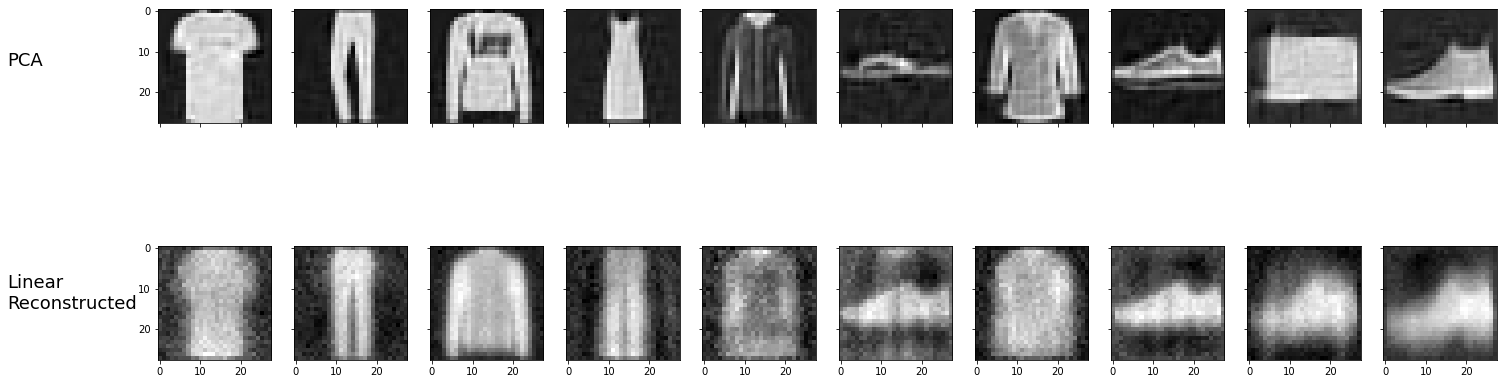

In [16]:
image_width = 28

fig, axes = plt.subplots(2, 10, sharex=True, sharey=True, figsize=(24, 8))
pca_images = [X_recovered[i] for i in indexes]
recon_images = [linear_reconstructions[0][i].detach().numpy() for i in indexes]
plt.text(-340, -45, f'PCA', fontsize=18);
plt.text(-340, 15, f'Linear\nReconstructed', fontsize=18);

for i in range(10):
    for ax, img in zip(axes, [pca_images, recon_images]):
        ax[i].imshow(img[i].reshape(image_width, image_width), cmap='gray')

As we can see the PCA reconstructions are much better. The Linear Autoencoder does an okay job but has some issues with the dress, the coat(sweater), the sandal, the shirt and the purse. Specifically, for the coat(sweater), it fails to add the sleeves. For the sandal, it completely fails to show some kind of sandal representation and shows a shoe mixed with a pants. For the shirt, it just shows the same thing as the coat(sweater) but more white pixels. Finally for the purse, it shows a boot like representation with a gray glow. 

### Visualization of input weight matrix of Linear Autoencoder vs PCA eigen images.

In this section we will compare the Eigen Images vs the Linear Autoencoders Weights. Keep in mind that there are only 8 neurons in the autoencoder's encode hiddle layer. Thus why we only have 8 images.

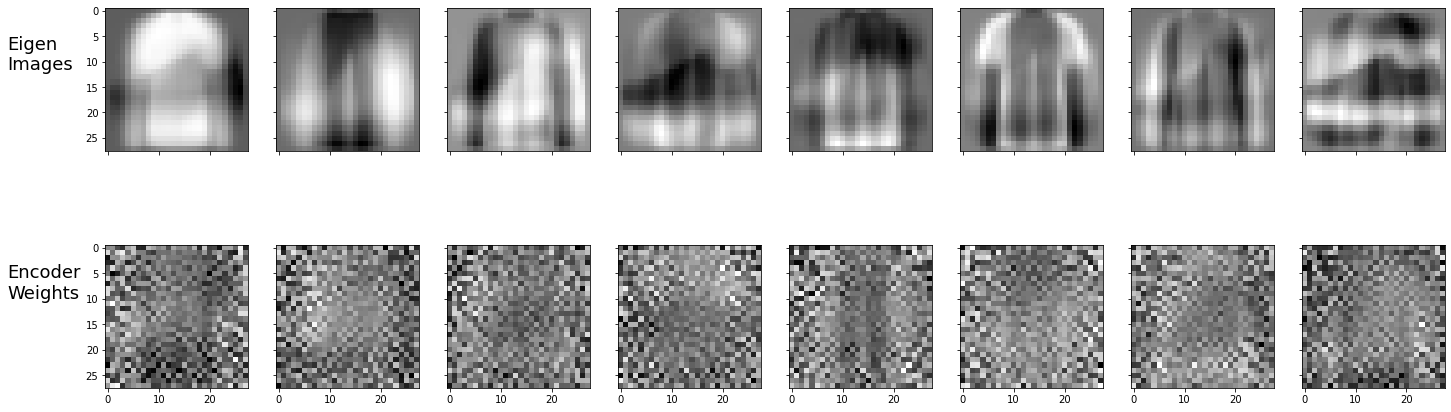

In [17]:
fig, axes = plt.subplots(2, 8, sharex=True, sharey=True, figsize=(24, 8))
weights = linear_model.linear_1.weight.detach().numpy()
plt.text(-255, -35, f'Eigen\nImages', fontsize=18);
plt.text(-255, 10, f'Encoder\nWeights', fontsize=18);
for i in range(8):
    for ax, img in zip(axes, [eigenimages, weights]):
        ax[i].imshow(img[i].reshape(image_width, image_width), cmap='gray')

As we can see the PCA Eigen Images are more clearer with not much noise compared to the linear autonencoder hidden layer weights. The only object I can faintly see behind all the noise for the linear autoencoder is a black pants in image 4.

## Visualize autoencoder’s hidden space using t-SNE

Lets us now visualize and compare the linear Autoencoder with PCA using t-SNE.

In [18]:
recon_output = list(map(lambda n: n.detach().numpy(), linear_reconstructions))
recon_output = np.concatenate(recon_output)
lin_tsne = TSNE(n_components=2, random_state=120)
lin_z = lin_tsne.fit_transform(recon_output)
lin_df = pd.DataFrame()
lin_df["y"] = dataset.targets
lin_df["comp-1"] = lin_z[:,0]
lin_df["comp-2"] = lin_z[:,1]


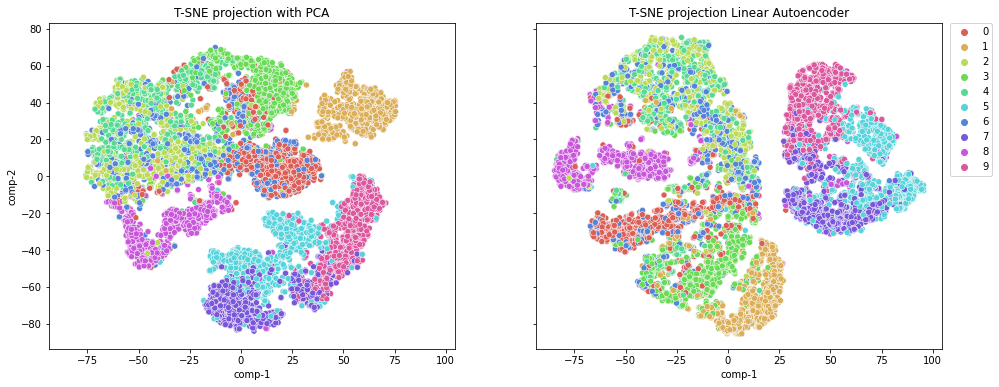

In [19]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6), sharex=True, sharey=True)
tn2 = sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(), palette=sns.color_palette("hls", 10), data=df_1, ax=ax1).set(title="T-SNE projection with PCA")
ax1.legend_.remove()

lin_tn = sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(), palette=sns.color_palette("hls", 10), data=lin_df, ax=ax2).set(title="T-SNE projection Linear Autoencoder")
ax2.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)


There are some changes that occur here. The most obvious the class clusters are moved around with respect to the grid but in terms of surrounding neighboring classes they are similar. The other notable changes are that:
* Class 8 is completely disconnected from the main classes
* Classes 5, 7, and 9 are rotated to create the gap between (class 7 and 9) to the other classes which are also rotated. This makes class 5 and class 8 farther from eachother.
* Class 0 is stretched out more.

## Nonlinear Autoencoder 

The Nonlinear Autoencoder is defined in the same cell as the Linear Autoencoder. It uses the same hyperparameters to have the results consistant.

In [20]:
torch.manual_seed(random_state)
nonlinear_model = NonLinearAutoencoder(n_features, n_hidden)
nonlinear_reconstructions = nonlinear_model.train(epochs, testloader, learning_rate)

/Users/adriansandoval/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1, Batch: 0, Cost: 1.3530 | Epoch: 1, Batch: 1, Cost: 1.3271 | Epoch: 1, Batch: 4, Cost: 1.2850 | Epoch: 1, Batch: 5, Cost: 1.2641 | Epoch: 1, Batch: 8, Cost: 1.2226 | Epoch: 1, Batch: 9, Cost: 1.1741 | Epoch: 1, Batch: 12, Cost: 1.1340 | Epoch: 1, Batch: 13, Cost: 1.0902 | Epoch: 1, Batch: 64, Cost: 0.6670 | Epoch: 1, Batch: 65, Cost: 0.6760 | Epoch: 1, Batch: 68, Cost: 0.6692 | Epoch: 1, Batch: 69, Cost: 0.6712 | Epoch: 1, Batch: 72, Cost: 0.6466 | Epoch: 1, Batch: 73, Cost: 0.6686 | Epoch: 1, Batch: 76, Cost: 0.6680 | Epoch: 1, Batch: 77, Cost: 0.6602 | Epoch: 2, Batch: 0, Cost: 0.6630 | Epoch: 2, Batch: 1, Cost: 0.6617 | Epoch: 2, Batch: 4, Cost: 0.6484 | Epoch: 2, Batch: 5, Cost: 0.6509 | Epoch: 2, Batch: 8, Cost: 0.6523 | Epoch: 2, Batch: 9, Cost: 0.6466 | Epoch: 2, Batch: 12, Cost: 0.6530 | Epoch: 2, Batch: 13, Cost: 0.6414 | Epoch: 2, Batch: 64, Cost: 0.6416 | Epoch: 2, Batch: 65, Cost: 0.6510 | Epoch: 2, Batch: 68, Cost: 0.6463 | Epoch: 2, Batch: 69, Cost: 0.6472 | Epoc

Now that we have the Nonlinear Autoencoder trained, lets compare the reconstructed images to those of PCA and the Linear Autoencoder.

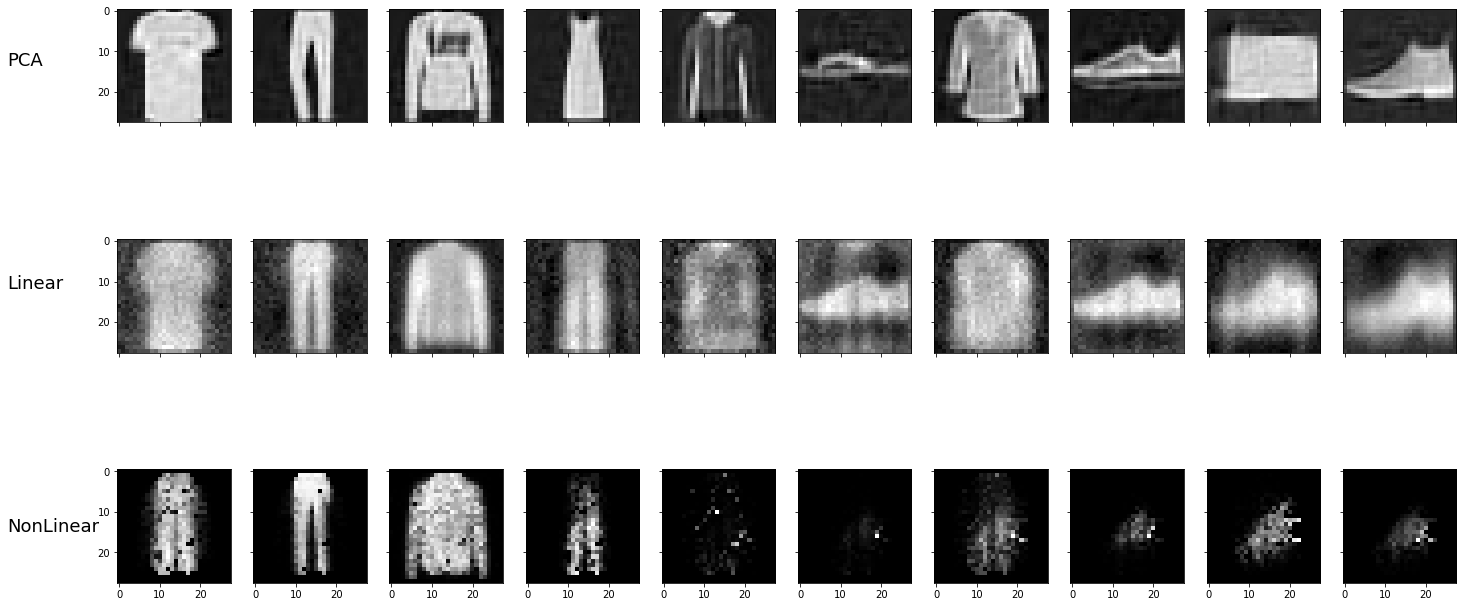

In [21]:
fig, axes = plt.subplots(3, 10, sharex=True, sharey=True, figsize=(24, 12))
nonlinear_recon_images = [nonlinear_reconstructions[0][i].detach().numpy() for i in indexes]
plt.text(-330, -100, f'PCA', fontsize=18);
plt.text(-330, -45, f'Linear', fontsize=18);
plt.text(-330, 15, f'NonLinear', fontsize=18);

for i in range(10):
    for ax, img in zip(axes, [pca_images, recon_images, nonlinear_recon_images]):
        ax[i].imshow(img[i].reshape(image_width, image_width), cmap='gray')

From the image above, we see that the NonLinear autoencoder does fairly well with class 1 (pants) and 2 (pullover). Class 0 (tee) seem a bit narrow but cannot depict it properly. The rest of the classes are pretty much unrecognized. PCA is clearly the winner here, but in terms of NonLinear vs Linear autoencoders its not soo clear. Maybe they both need more training to get a distinct winner. My hypothesis is that the NonLinear autoencoder would preform better if trained for longer and it's reconstructing the images better with less noise.

Now, lets see compare the Eigen Images, Linear Weights, and NonLinear Weights.

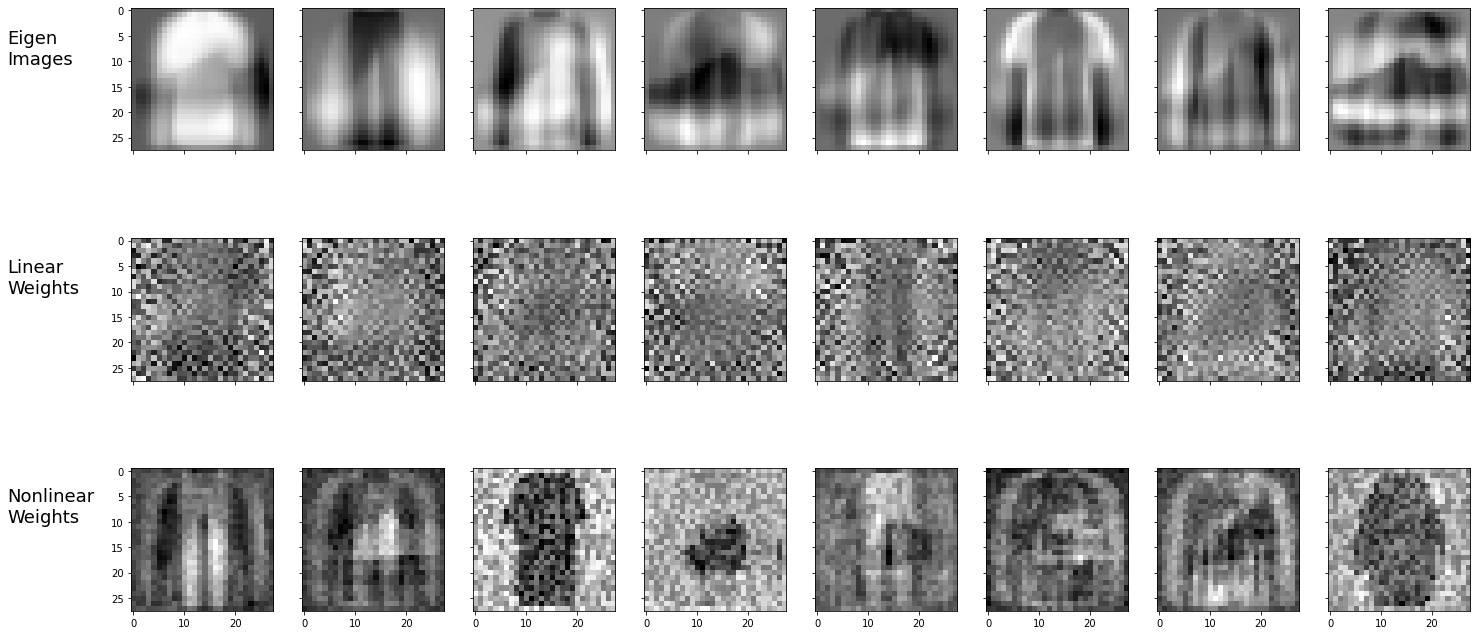

In [22]:
fig, axes = plt.subplots(3, 8, sharex=True, sharey=True, figsize=(24, 12))
nonlinear_weights = nonlinear_model.linear_1.weight.detach().numpy()
plt.text(-260, -80, f'Eigen\nImages', fontsize=18);
plt.text(-260, -35, f'Linear\nWeights', fontsize=18);
plt.text(-260, 10, f'Nonlinear\nWeights', fontsize=18);
for i in range(8):
    for ax, img in zip(axes, [eigenimages, weights,nonlinear_weights]):
        ax[i].imshow(img[i].reshape(image_width, image_width), cmap='gray')

Again the PCA Eigen images are more well defined and the linear weights from the linear autoencoder are filled with noise with little depiction. Now the Nonlinear Autoencoder's weights seem to be somehere in the middle. We can vaguely depict some class representations but not clearly as the PCA. Overall, in terms of weights the nonlinear autoencoder is better than the linear autoencoder but lack behind PCA. This could of course be improved by increasing the epoch in the training.

Lets now look into visualizing the results with t-SNE.

In [23]:
nl_recon_output = list(map(lambda n: n.detach().numpy(), nonlinear_reconstructions))
nl_recon_output = np.concatenate(nl_recon_output)
nlin_tsne = TSNE(n_components=2, random_state=120)
nlin_z = nlin_tsne.fit_transform(nl_recon_output)
nlin_df = pd.DataFrame()
nlin_df["y"] = dataset.targets
nlin_df["comp-1"] = nlin_z[:,0]
nlin_df["comp-2"] = nlin_z[:,1]

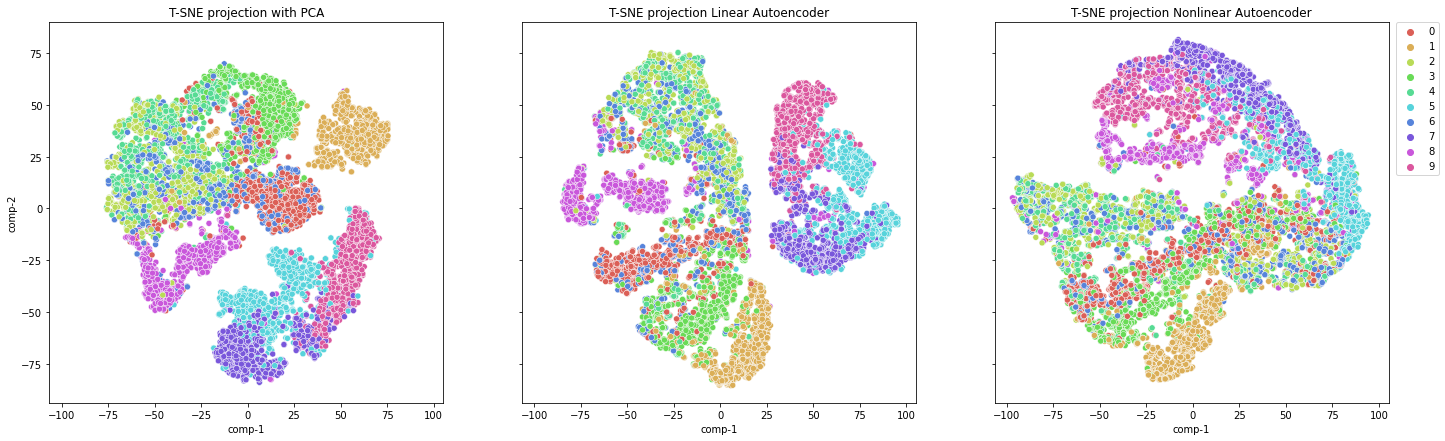

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(24,7), sharex=True, sharey=True)
tn2 = sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(), palette=sns.color_palette("hls", 10), data=df_1, ax=ax1).set(title="T-SNE projection with PCA")
ax1.legend_.remove()
lin_tn = sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(), palette=sns.color_palette("hls", 10), data=lin_df, ax=ax2).set(title="T-SNE projection Linear Autoencoder")
ax2.legend_.remove()

t = sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(), palette=sns.color_palette("hls", 10), data=nlin_df, ax=ax3).set(title="T-SNE projection Nonlinear Autoencoder")
ax3.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

As we can see, the three methods have very different clusters shapes and locations. Overall classes 0, 1, 2, 3, and 4 stayed close to it's respective neighbors. Classes 8 and 5 where the most moved around and most drastict changes. The Nonlinear Autoencoder's data seems to spread, stretch, and overlap most of the data.

## K-means culstering

The model is using k-means++ for intialization of centroids.

In [25]:
sse = []
# gather the SSE's for cluster 8 - 12
for i in range(8, 13):
    kmeans = KMeans(n_clusters=i, random_state=120).fit(images)
    sse.append(kmeans.inertia_)


Lets now plot the SSE vs K Clusters. Before we continue, i'll be plotting a normal slope line to better depict the slight 'elbow' curve of K clusters vs SSE.

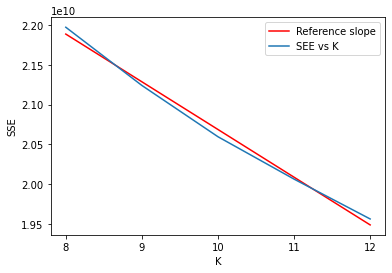

In [26]:
k = np.arange(8, 13, step=1)
slope, intercept = np.polyfit(k, sse, 1) # for reference only
abline_values = [slope * i + intercept for i in k] # for reference only
plt.plot(k, abline_values, 'r') # for reference only
plt.plot(k, sse)
plt.xticks(k)
plt.xlabel('K')
plt.ylabel('SSE')
leg1 = f"Reference slope"
leg2 = f"SEE vs K"
plt.legend([leg1, leg2])

Firstly if we ignore the redline and although the SSE decreases with K increasing the difference isn't much. If following the elbow method to choose the best K, we can see a slight bend at K = **10**.